# Customer Assignment Problem

## Objective and Prerequisites

Sharpen your mathematical optimization modeling skills with this example, in which you will learn how to select the location of facilities based on their proximity to customers. We’ll demonstrate how you can construct a mixed-integer programming (MIP) model of this facility location problem, implement this model in Pyomo, and generate an optimal solution using the CBC Optimizer.

---

## Motivation

Many companies in various industries must, at some point, make strategic decisions about where to build facilities to support their operations. For example:

- Producers of goods need to decide how to design their supply chains – which encompass factories, distribution centers, warehouses, and retail stores.
- Healthcare providers need to determine where to build hospitals to maximize their population coverage.

These are strategic decisions that are difficult to implement and costly to change because they entail long-term investments. Furthermore, these decisions have a significant impact, both in terms of customer satisfaction and cost management. One of the critical factors to consider in this process is the location of the customers that the company is planning to serve.

---

## Problem Description

The Customer Assignment Problem is closely related to the Facility Location Problem, which is concerned with the optimal placement of facilities (from a set of candidate locations) in order to minimize the distance between the company's facilities and the customers. When the facilities have unlimited capacity, customers are assumed to be served by the closest facility.

In cases where the number of customers considered is too big, the customers can be grouped into clusters. Then, the cluster centers can be used in lieu of the individual customer locations. This pre-processing makes the assumption that all customers belonging to a given cluster will be served by the facility assigned to that cluster. The k-means algorithm can be used for this task, which aims to partition $n$ objects into $k$ distinct and non-overlapping clusters.

---

## Solution Approach

Mathematical optimization is a declarative approach where the modeler formulates a mathematical optimization model that captures the key aspects of a complex decision problem.

A mathematical optimization model has five components, namely:

- Sets and indices.
- Parameters.
- Decision variables.
- Objective function(s).
- Constraints.

We now present a Binary Integer Programming (BIP) formulation:

### Sets and Indices

$i \in I$: Set of customer clusters.

$j \in J$: Set of potential facility locations.

$\text{Pairings}= \{(i,j) \in I \times J: \text{dist}_{i,j} \leq \text{threshold}\}$: Set of allowed pairings

### Parameters

$\text{threshold} \in \mathbb{R}^+$: Maximum distance for a cluster-facility pairing to be considered.

$\text{max\_facilities} \in \mathbb{N}$: Maximum number of facilities to be opened.

$\text{weight}_{i} \in \mathbb{N}$: Number of customers in cluster $i$.

$\text{dist}_{i,j} \in \mathbb{R}^+$: Distance from cluster $i$ to facility location $j$.

### Decision Variables

$\text{select}_{j} \in \{0,1\}$: 1 if facility location $j$ is selected; 0 otherwise.

$\text{assign}_{i,j} \in \{0,1\}$: 1 if cluster $i$ is assigned to facility location $j$; 0 otherwise.

### Objective Function

- **Total distance**: Minimize the total distance from clusters to their assigned facility:

\begin{equation}
\text{Min} \quad Z = \sum_{(i,j) \in \text{Pairings}}\text{weight}_{i} \cdot \text{dist}_{i,j} \cdot \text{assign}_{i,j}
\tag{0}
\end{equation}

### Constraints

- **Facility limit**: The number of facilities built cannot exceed the limit:

\begin{equation}
\sum_{j}\text{select}_{j} \leq \text{maxfacilities}
\tag{1}
\end{equation}

- **Open to assign**: Cluster $i$ can only be assigned to facility $j$ if we decide to build that facility:

\begin{equation}
\text{assign}_{i,j} \leq \text{select}_{j} \quad \forall (i,j) \in \text{Pairings}
\tag{2}
\end{equation}

- **Closest store**: Cluster $i$ must be assigned to exactly one facility:

\begin{equation}
\sum_{j:(i,j) \in \text{Pairings}}\text{assign}_{i,j} = 1 \quad \forall i \in I
\tag{3}
\end{equation}

---

## Python Implementation

### Dataset Generation

In this simple example, we choose random locations for customers and facility candidates. Customers are distributed using Gaussian distributions around a few randomly chosen population centers, whereas facility locations are uniformly distributed.


In [11]:
import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import MiniBatchKMeans
import pyomo.environ as pyo

seed = 10101
num_customers = 50_000
num_candidates = 20
max_facilities = 8
num_clusters = 100
num_gaussians = 15
threshold = 0.99

random.seed(seed)
customers_per_gaussian = np.random.multinomial(
    num_customers, [1 / num_gaussians] * num_gaussians
)
customer_locs = []
for i in range(num_gaussians):
    # each center coordinate in [-0.5, 0.5]
    center = (random.random() - 0.5, random.random() - 0.5)
    customer_locs += [
        (random.gauss(0, 0.1) + center[0], random.gauss(0, 0.1) + center[1])
        for i in range(customers_per_gaussian[i])
    ]

# each candidate coordinate in [-0.5, 0.5]
facility_locs = [
    (random.random() - 0.5, random.random() - 0.5) for i in range(num_candidates)
]

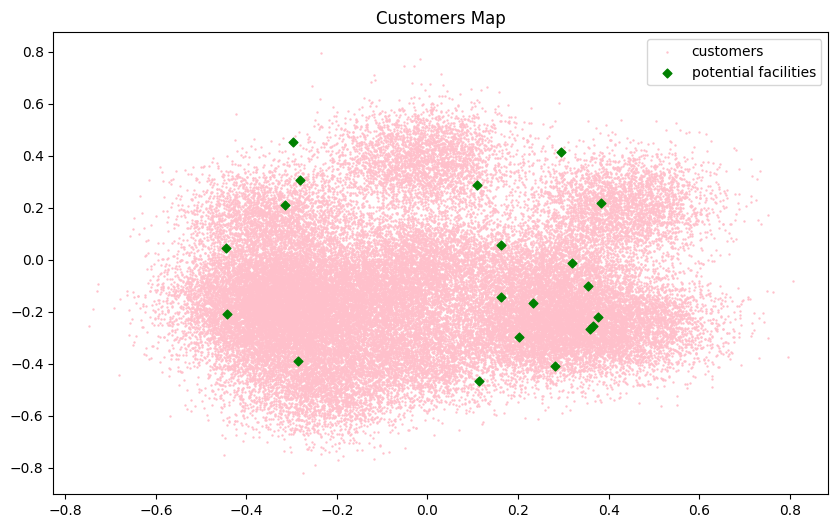

In [12]:
plt.figure(figsize=(10, 6))
plt.scatter(*zip(*customer_locs), c="Pink", s=0.5, marker="o", label="customers")
plt.scatter(
    *zip(*facility_locs), c="Green", s=20, marker="D", label="potential facilities"
)
plt.legend()
plt.title("Customers Map")
plt.show()

### Preprocessing

**Clustering**

To limit the size of the optimization model, we group individual customers into clusters and optimize on these clusters. Clusters are computed using the K-means algorithm, as implemented in the scikit-learn package.


In [13]:
kmeans = MiniBatchKMeans(
    n_clusters=num_clusters, init_size=3 * num_clusters, random_state=seed
).fit(customer_locs)
memberships = list(kmeans.labels_)
centroids = list(kmeans.cluster_centers_)  # Center point for each cluster
weights = list(
    np.histogram(memberships, bins=num_clusters)[0]
)  # Number of customers in each cluster
print("First cluster center:", centroids[0])
print("Weights for first 10 clusters:", weights[:10])

First cluster center: [ 0.34146121 -0.40705193]
Weights for first 10 clusters: [428, 456, 543, 559, 365, 767, 718, 505, 643, 595]


/Users/vito/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


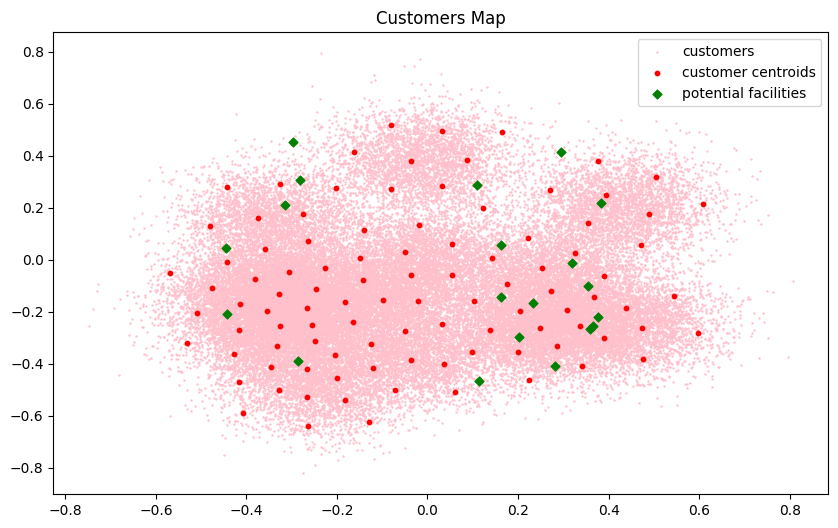

In [14]:
plt.figure(figsize=(10, 6))
plt.scatter(*zip(*customer_locs), c="Pink", s=0.5, label="customers")
plt.scatter(*zip(*centroids), c="Red", s=10, label="customer centroids")
plt.scatter(
    *zip(*facility_locs), c="Green", marker="D", s=20, label="potential facilities"
)
plt.legend()
plt.title("Customers Map")
plt.show()

**_Viable Customer-Store Pairings_**

Some facilities are just too far away from a cluster center to be relevant, so let's heuristically filter all distances that exceed a given `threshold`:


In [15]:
def dist(loc1, loc2):
    return np.linalg.norm(loc1 - loc2, ord=2)  # Euclidean distance


pairings = {
    (facility, cluster): dist(facility_locs[facility], centroids[cluster])
    for facility in range(num_candidates)
    for cluster in range(num_clusters)
    if dist(facility_locs[facility], centroids[cluster]) < threshold
}
print("Number of viable pairings: {0}".format(len(pairings.keys())))

Number of viable pairings: 1948


### Model Deployment

Build facilities from among candidate locations to minimize total distance to cluster centers:


In [16]:
m = pyo.ConcreteModel("Facility location")

# Decision variables: select facility locations
m.select = pyo.Var(range(num_candidates), domain=pyo.Binary, name="select")
# Decision variables: assign customer clusters to a facility location
m.assign = pyo.Var(
    pairings.keys(),
    domain=pyo.Binary,
    name="assign",
)

# 0. Objective Function: Total distance
obj = pyo.quicksum(
    weights[cluster] * pairings[facility, cluster] * m.assign[facility, cluster]
    for facility, cluster in pairings.keys()
)
m.obj = pyo.Objective(rule=obj, sense=pyo.minimize)


# 1. Facility limit
m.facility_limit = pyo.Constraint(
    rule=sum(m.select[c] for c in range(num_candidates)) <= max_facilities
)


# 2. Open to assign
def open_to_assign(m, facility, cluster):
    return m.assign[facility, cluster] <= m.select[facility]


m.open_to_assign = pyo.Constraint(
    pairings.keys(),
    rule=open_to_assign,
)


# # 3. Closest store
def closest_store(m, cluster):
    return (
        sum(
            m.assign[facility, cluster]
            for facility in range(num_candidates)
            if pairings.get((facility, cluster), None)
        )
        == 1
    )


m.closest_store = pyo.Constraint(range(num_clusters), rule=closest_store)

In [17]:
# solve
pyo.SolverFactory("cbc").solve(m).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 7331.82175716
  Upper bound: 7331.82175716
  Number of objectives: 1
  Number of constraints: 2049
  Number of variables: 1968
  Number of binary variables: 1968
  Number of integer variables: 1968
  Number of nonzeros: 1948
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.03
  Wallclock time: 0.03
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statist

## Analysis

Let's plot a map with:

- Customer locations represented as small pink dots.
- Customer cluster centroids represented as large red dots.
- Facility location candidates represented as green dots. Notice that selected locations have black lines emanating from them towards each cluster that is likely to be served by that facility.


In [18]:
assignments = [p for p in pairings if m.assign[p].value > 0.5]

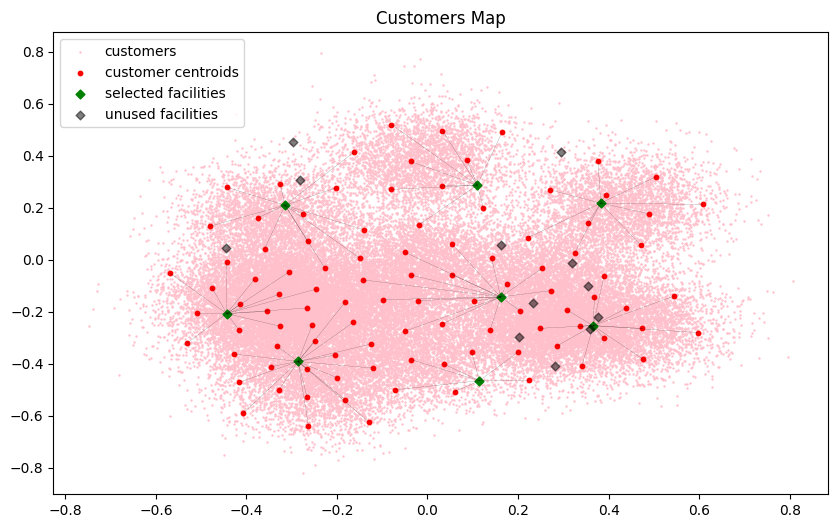

In [19]:
plt.figure(figsize=(10, 6))
plt.scatter(*zip(*customer_locs), c="Pink", s=0.5, label="customers")
plt.scatter(*zip(*centroids), c="Red", s=10, label="customer centroids")

for p in assignments:
    pts = [facility_locs[p[0]], centroids[p[1]]]
    plt.plot(*zip(*pts), c="Black", linewidth=0.1)

plt.scatter(
    *zip(*[facility_locs[f] for f in set([p[0] for p in assignments])]),
    c="Green",
    s=20,
    marker="D",
    label="selected facilities"
)
plt.scatter(
    *zip(
        *[
            facility_locs[f]
            for f in range(num_candidates)
            if f not in set([p[0] for p in assignments])
        ]
    ),
    c="black",
    s=20,
    alpha=0.5,
    marker="D",
    label="unused facilities"
)

plt.legend()
plt.title("Customers Map")
plt.show()

## Conclusions

We learned how mathematical optimization can be used to solve the Customer Assignment Problem. Moreover, it has been shown how machine learning can be used in the pre-processing so as to reduce the computational burden of big datasets. Of course, this comes at a cost, as using fewer clusters will result in coarser approximations to the global optimal solution.

## References

1. Drezner, Z., & Hamacher, H. W. (Eds.). (2001). Facility location: applications and theory. Springer Science & Business Media.
2. James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An introduction to statistical learning. New York: springer.
3. Klose, A., & Drexl, A. (2005). Facility location models for distribution system design. European journal of operational research, 162(1), 4-29.
